### Load documents from GIT Repository
Langchain `DocumentLoaders` load data into the standard LangChain `Document` format. We can use components provided by langchain or any custom loader implementing `DocumentLoader` interface.

Some of available loaders in [langchain_community.document_loaders](https://python.langchain.com/docs/integrations/document_loaders/):
- **Webpages**: allow you to load webpages.
- **PDFs**: allow you to load PDF documents.
- **Cloud Providers**: allow you to load documents from your favorite cloud providers.
- **Tools**: allow you to load data from commonly used tools like Slack, Quip, Github and more..
- **Local**: allow you to load data from your local file system.

In order to load files from GIT repository we can use `GitLoader` community package that will allow to load reposiitory data, where each document would represent one file in the repository.

We can also utilize `GitPython` package to clone repository and retreive another useful information.

```
> pip install --upgrade --quiet  GitPython
```


In [ ]:
from typing import Iterator
from git import Repo
from langchain_core.documents import Document
from langchain_community.document_loaders import GitLoader

jsLoader = GitLoader(repo_path="./local-repository/", branch='master', file_filter=lambda file_path: file_path.endswith(".js"))
mdLoader = GitLoader(repo_path="./local-repository/", branch='master', file_filter=lambda file_path: file_path.endswith(".md"))
defaultLoader = GitLoader(repo_path="./local-repository/", branch='master', file_filter=lambda file_path: not file_path.endswith(".md") and not file_path.endswith(".js"))

jsData = jsLoader.load()
mdData = mdLoader.load()
otherData = defaultLoader.load()

print(len(jsData))
print(len(mdData))
print(len(otherData))

#print(mdData[0])
#print(jsData[1])
#print(otherData[3])

repo = Repo("./local-repository/")
def get_changed_files():
    changed_files = []
    diff_index = repo.index.diff(None)
    for diff_item in diff_index:
        changed_files.append(diff_item.a_path)

    return changed_files

def get_commits_from_branch(branch_name):
    branch = next(filter(lambda b: b.name == branch_name, repo.branches), None)
    if (branch is not None):        
        commits = list(branch.commit.iter_items(repo, branch.commit))    
        return [commit.message for commit in commits]
    ref = next(filter(lambda b: b.name == f"origin/{branch_name}", repo.remote().refs), None)
    if ref is not None:        
        commits = list(repo.iter_commits(ref))    
        return [commit.message for commit in commits]    
    return []

def load_commits() -> Iterator[Document]:
    for commit in repo.iter_commits():
        metadata = {
            "commit_author_name": commit.author.name,
            "commit_author_email": commit.author.email,
            "commit_authored_datetime": commit.authored_datetime,
            "commit_committed_datetime": commit.committed_datetime,
        }
        yield Document(page_content=commit.message, metadata=metadata)

commits_data = list(load_commits())

print(len(commits_data))
#print(commitsData[0])

### Tokenize and Split documents into chunks

There are different ways to split a document into chunks, the most challenging part that we need to consider is to split the document into meaningful chunks, and it can strongly depend on the document type and the use case.

In our case there are 3 types of documents we can consider:
  - **Text documents**: We can split the text into paragraphs, sentences, or words.
  - **Code documents**: We can split the code into functions, classes, or lines.
  - **Git data**: We can split the git data into commits, files, or lines.

Splitters supported by [langchain.text_splitter](https://python.langchain.com/v0.2/api_reference/text_splitters/index.html) that we can use:
  - **RecursiveCharacterTextSplitter**: Implementation of splitting text that recursively looks at characters.
  - **MarkdownHeaderTextSplitter**: Implementation of splitting markdown files based on specific headers.
  - **TokenTextSplitter**: Implementation of splitting text that looks at tokens.
  - **SentenceTransformersTokenTextSplitter**: It is a specialized text splitter for use with the sentence-transformer models. The default behaviour is to split the text into chunks that fit the token window of the sentence transformer model that you would like to use.
  - **RecursiveJsonSplitter**: Implementation of splitting text that looks at characters. Recursively tries to split by different characters to find the one that works.
  - **Language**: for CPP, Python, Ruby, etc...


In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter, MarkdownTextSplitter, Language, TokenTextSplitter, SentenceTransformersTokenTextSplitter

js_splitter = RecursiveCharacterTextSplitter.from_language(
    language=Language.JS, chunk_size=100, chunk_overlap=0
)
md_splitter = MarkdownTextSplitter(chunk_size=100, chunk_overlap=10)
token_splitter = TokenTextSplitter(chunk_size=100, chunk_overlap=10)
sentence_splitter = SentenceTransformersTokenTextSplitter()

js_docs = js_splitter.split_documents(jsData)
md_docs = md_splitter.split_documents(mdData)
other_docs = token_splitter.split_documents(otherData)
commit_docs = sentence_splitter.split_documents(commits_data)


print(len(commit_docs))
print(len(js_docs))
print(len(md_docs))
print(len(other_docs))

#print(js_docs[0])
#print(md_docs[0])
#print(other_docs[0])
#print(commit_docs[0])


### Create embedding vectors

Embeddings are essential for LLM tasks, they are high-dimensional vectors that capture the semantic meaning of tokens in chunks. We will use them for document corpus and for the query to search for relevant chunks that will be included into the context to generate completions.

From this point we need to find a structure of contextual query to find proper documents for suggestion. Lets assume it will be changes in the code of current document. We can use `GitPython` to get the changes in the repository and use them as a query.

To understand embeddings and how they aligned you can play with text embeddings in Cohere Playground (https://dashboard.cohere.com/playground/embed)


In [ ]:
import asyncio
import numpy
from langchain_openai import OpenAIEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_ollama import OllamaEmbeddings
from sentence_transformers import SentenceTransformer

sbertEmb = SentenceTransformer('all-MiniLM-L6-v2')
# transformer = models.Transformer("sentence-transformers/all-MiniLM-L6-v2", max_seq_length=256)
# pooling = models.Pooling(transformer.get_word_embedding_dimension(), pooling_mode="mean")
# normalize = models.Normalize()
# model = SentenceTransformer(modules=[transformer, pooling, normalize])

openAIEmb = OpenAIEmbeddings(api_key="OPENAI_API_KEY")
hfEmb = HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2') #sentence-transformers/all-mpnet-base-v2
ollamaEmb = OllamaEmbeddings(model="llama3.2:1b")
starCoderEmb = OllamaEmbeddings(model="starcoder2:3b")

(js_embeddings, md_embeddings) = await asyncio.gather(
    openAIEmb.aembed_documents([doc.page_content for doc in js_docs]),
    ollamaEmb.aembed_documents([doc.page_content for doc in md_docs])
    )

commit_embeddings = sbertEmb.encode([doc.page_content for doc in commit_docs], convert_to_tensor=True) # hfEmb.embed_documents(md_docs)

print(len(js_embeddings))
print(len(md_embeddings))
print(len(commit_embeddings))

# print vector dimensions
print(len(js_embeddings[0]))
print(len(md_embeddings[0]))
print(commit_embeddings.shape)

# understanding embeddings
# https://dashboard.cohere.com/playground/embed
# mother, father, aunt, uncle
plur = numpy.subtract(openAIEmb.embed_query("students"), openAIEmb.embed_query("student"))

print(numpy.dot(plur, openAIEmb.embed_query("cat")))
print(numpy.dot(plur, openAIEmb.embed_query("cats")))

### Load data to Vector DB
Vector DBs are very diverse, they support different types of embedding models and different types of search and API capabilities. Most of them support `langchain` models.



In [ ]:
# Simple In-Memory
# Chroma
# Faiss
# Qdrant

import faiss
import uuid
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

in_memory_vector_store = InMemoryVectorStore(openAIEmb)

faiss_vec_dim = commit_embeddings.shape[1] # vector size of size of sentence-BERT embeddings
faiss_index = faiss.IndexFlatL2(faiss_vec_dim)
faiss_index.train(commit_embeddings)
faiss_vector_store = FAISS(
    embedding_function=hfEmb,
    index=faiss_index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

client = QdrantClient(":memory:")
client.create_collection(
    collection_name="text_collection",
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE), # 1536 - vector size of 'text-embedding-ada-002' OpenAI embeddings
)
client.create_collection(
    collection_name="text_collection_hf",
    vectors_config=VectorParams(size=768, distance=Distance.COSINE), # 768 - vector size of SBERT embeddings
)
client.create_collection(
    collection_name="code_collection",
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE), # 1536 - vector size of 'text-embedding-ada-002' OpenAI embeddings
)
client.create_collection(
    collection_name="code_collection_sc",
    vectors_config=VectorParams(size=3072, distance=Distance.COSINE), # 3072 - default vector size of starcoder2 embeddings
)
client.create_collection(
    collection_name="docs_collection",
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE), # 1536 - vector size of 'text-embedding-ada-002' OpenAI embeddings
)
client.create_collection(
    collection_name="generic_collection_hf_384",
    vectors_config=VectorParams(size=384, distance=Distance.COSINE), # 384 - vector size of sentence-transformers/all-MiniLM-L6-v2 embeddings
)
qdrant_vector_store = QdrantVectorStore(
    client=client,
    collection_name="docs_collection",
    embedding=openAIEmb, #ollamaEmb
)

# Add documents to the vector stores
in_memory_vector_store.add_documents(documents=js_docs)

qdrant_vector_store.add_documents(documents=md_docs)

uuids = [str(uuid.uuid4()) for _ in range(len(commit_docs))]
faiss_vector_store.add_documents(documents=commit_docs, ids=uuids)
# FAISS.from_documents()

### Search vectorized data
In `Langchain`, components that are responsible to returns documents given an unstructured query ara called `Retreivers`, responsible for finding the most relevant documents along with its "relativity" to the query if possible.

Retreivers, availabl for `langchain` integration can be found here https://python.langchain.com/docs/integrations/retrievers/ along with the usage guide https://python.langchain.com/docs/how_to/#retrievers

We will start from vectorized data search capabilities based on vector store-backed retriever and search specific to certain types of stores.

In [ ]:
import torch
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from sentence_transformers import SimilarityFunction
from sentence_transformers import util
from langchain_qdrant import QdrantVectorStore

current_diff = repo.git.diff()
#print(current_diff)

js_retriever = in_memory_vector_store.as_retriever(k=3) # similarity, mmf, scored similarity
# js_retriever = in_memory_vector_store.as_retriever(search_type="similarity_score_threshold", search_kwargs={"score_threshold": 0.5}, k=1)
similar_js_docs = js_retriever.invoke(current_diff)
print("similar js docs")
print(similar_js_docs)

# summarize current diff to search info in commits
chat = ChatOpenAI(model="gpt-4o-mini", api_key="OPENAI_API_KEY")
summary_template = ChatPromptTemplate.from_template("Create short meaningful commit message of git diff.\n{git_diff}")
# Try FewShotChatMessagePromptTemplate with example prompts
summary_chain = summary_template | chat | StrOutputParser()
summary = summary_chain.invoke({"git_diff":current_diff})
print(f"summary: {summary}")

# similarity search by query, vector and score
summary_embeddings = hfEmb.embed_query(summary)
similar_commits = faiss_vector_store.similarity_search_by_vector(summary_embeddings) # ANN search
print("FAISS similar commits")
print(similar_commits)

similar_commits_score = faiss_vector_store.similarity_search_with_score(summary, k=2)
print("FAISS similar commits with score")
for (doc, score) in similar_commits_score:
    print(f"[{score}] {doc.page_content}")

remote_commits = get_commits_from_branch("with_router")

# SBERT smantic search (ENN search)
# Select model depending on Symmetric vs Asymmetric Semantic Search
sbertEmb.similarity_fn_name = SimilarityFunction.DOT_PRODUCT # SimilarityFunction.COSINE, etc.
# model processing options can be cpu or gpu
# convert_to_tensor=True" is used to keep the tensors on GPU (if available)
commits_emb = sbertEmb.encode(remote_commits, convert_to_tensor=True)
summary_emb = sbertEmb.encode([summary], convert_to_tensor=True)
commit_similarities = sbertEmb.similarity(summary_emb, commits_emb)[0] # pairwise_similarity
scores, indices = torch.topk(commit_similarities, k=2)
print("SBERT similar commits")
for score, idx in zip(scores, indices):
    print(f"[{score:.4f}] {remote_commits[idx]}".rstrip())

# speed optimization
# pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
#sbertEmbGpu = SentenceTransformer('all-MiniLM-L6-v2', device="cuda")
#commits_emb_gpu = sbertEmb.encode(remote_commits, convert_to_tensor=True).to("cuda")
#commits_emb_gpu = util.normalize_embeddings(commits_emb_gpu) # ENN
#summary_emb_gpu = summary_emb.to("cuda")
#summary_emb_gpu = util.normalize_embeddings(summary_emb_gpu)
#hits = util.semantic_search(summary_emb_gpu, commits_emb_gpu, score_function=util.dot_score)
#print("GPU similar commits")
#print(hits)

# FAISS specific search with performance improvements
new_index = faiss.IndexIVFFlat(faiss_index, commit_embeddings.shape[1], 2)
new_index.train(commit_embeddings)
new_index.add(commit_embeddings)
#d,i = new_index.search(summary_emb, k=1)
print("FAISS specific search")
#print(i)

# understanding relevance, score
qdrant_test_store = QdrantVectorStore(
    client=client,
    collection_name="text_collection",
    embedding=openAIEmb
)

qdrant_test_store.add_texts(["She deposited money at the bank.","The boat was tied to the river bank."])

bank_relevance = qdrant_test_store.similarity_search_with_relevance_scores("steep bank")
bank_score = qdrant_test_store.similarity_search_with_score("steep bank")

print(bank_relevance)
print(bank_score)

bank_relevance = qdrant_test_store.similarity_search_with_relevance_scores("reliable bank")
bank_score = qdrant_test_store.similarity_search_with_score("reliable bank")

print(bank_relevance)
print(bank_score)

Let's reveal what we can get from Maximal Marginal Relevance (MMR) and how it can be used to improve search results.

In [ ]:
from langchain_qdrant import QdrantVectorStore
from langchain.chains.qa_with_sources.retrieval import RetrievalQAWithSourcesChain

qdrant_code_store = QdrantVectorStore(
    client=client,
    collection_name="code_collection",
    embedding=openAIEmb
)

# MMR example
# Base code snippets with slight variations
BASE_SNIPPET_0 = """
def add_numbers(a, b):
    return a + b  # Adds two numbers
"""

BASE_SNIPPET_1 = """
def sum_values(x, y):
    result = x + y  # Returns the sum of two values
    return result
"""

BASE_SNIPPET_2 = """
def calculate_sum(num1, num2):
    total = num1 + num2
    return total  # Returns total of num1 and num2
"""

BASE_SNIPPET_3 = """
def add_two_values(value1, value2):
    return value1 + value2  # Adding two numbers together
"""

# A snippet with a slightly different functionality
DIFFERENT_SNIPPET = """
def multiply_numbers(x, y):
    return x * y  # Multiplies two numbers
"""

# Insert into index
code_snippets = [
    BASE_SNIPPET_0,
    BASE_SNIPPET_1,
    BASE_SNIPPET_2,
    BASE_SNIPPET_3,
    DIFFERENT_SNIPPET,
]
metadatas = [
    {"source": "Common Python Utilities"},
    {"source": "Common Python Utilities"},
    {"source": "Common Python Utilities"},
    {"source": "Common Python Utilities"},
    {"source": "Mathematical Operations Module"},
]

qdrant_code_store.add_texts(code_snippets, metadatas=metadatas)

QUESTION = "How do I perform basic arithmetic operations in Python? Use one sentence with function reference."

retriever_sim = qdrant_code_store.as_retriever(search_type="similarity", search_kwargs={ "k": 2})

qa_chain_sim = RetrievalQAWithSourcesChain.from_chain_type(
    chat,
    retriever=retriever_sim,
    return_source_documents=True,
)

result = qa_chain_sim({"question": QUESTION})

print("Similarity-based chain:")
print("Answer:", result['answer'].strip())
print("Sources:", result['sources'].strip())

retriever_mmr = qdrant_code_store.as_retriever(search_type="mmr", search_kwargs={ "k": 2})

# 
qa_chain_mmr = qa_chain_sim = RetrievalQAWithSourcesChain.from_chain_type(
    chat,
    retriever=retriever_mmr,
    return_source_documents=True,
)

result = qa_chain_mmr({"question": QUESTION})

print("\nMMR-based chain:")
print("Answer:", result['answer'].strip())
print("Sources:", result['sources'].strip())

Let's try more examplew with code similarity search, trying to analyze multi modal codebase

In [ ]:
from tree_sitter_languages import get_parser
from langchain_qdrant import QdrantVectorStore

# code similarity
sort = """
void f(int[] array) {
    boolean swapped = true;
    for (int i = 0; i < array.length && swapped; i++) {
        swapped = false;
        for (int j = 0; j < array.length - 1 - i; j++) {
           if (array[j] > array[j+1]) {
               int temp = array[j];
               array[j] = array[j+1];
               array[j+1]= temp;
               swapped = true;
           }
        }
    }
}
"""

stddev = """
const f = (trials, len) => {
    let sum = 0;
    let squ = 0.0;

    for (let i = 0; i < len; i++) {
        let d = trials[i];
        sum += d;
        squ += d * d;
    }

    let x = squ - (sum * sum) / len;
    let res = Math.sqrt(x / (len - 1));

    return Math.floor(res);
};
"""

indexOf = """
function f(array, value) {
    for (let i = 0; i < array.length; i++) {
        if (array[i] === value) {
            return i;
        }
    }
    return -1;
}
"""

sql_query = "SELECT * FROM customers WHERE city = 'Berlin'"

qdrant_code_store = QdrantVectorStore(
    client=client,
    collection_name="code_collection_sc",
    embedding=starCoderEmb
)

qdrant_code_store.add_texts(
    [sort, stddev, indexOf],
    metadatas=[{"source": "sort"}, {"source": "stddev"}, {"source": "indexOf"}],
)

qdrant_ast_store = QdrantVectorStore(
    client=client,
    collection_name="code_collection",
    embedding=openAIEmb
)

sort_relevance = qdrant_code_store.similarity_search_with_relevance_scores("sort")
sort_score = qdrant_code_store.similarity_search_with_score("sort")

print("Code similarity with starcoder2 embeddings")
print(sort_relevance)
print(sort_score)

sql_relevance = qdrant_code_store.similarity_search_with_relevance_scores(sql_query)
sql_score = qdrant_code_store.similarity_search_with_score(sql_query)

print("SQL Code similarity with starcoder2 embeddings")
print(sql_relevance)
print(sql_score)

# code similarity with tree-sitter AST
js_parser = get_parser('javascript')
sql_parser = get_parser('sql')
java_parser = get_parser('java')

ts_query = sql_parser.parse(sql_query.encode()).root_node.sexp()

ts_indexOf = js_parser.parse(indexOf.encode()).root_node.sexp()
ts_stdev = js_parser.parse(stddev.encode()).root_node.sexp()
ts_sort = java_parser.parse(sort.encode()).root_node.sexp()

qdrant_ast_store.add_documents([
    Document(page_content=ts_sort, metadata={'source':'ts_sort', 'source_code': sort, 'language':'java'}), 
    Document(page_content=ts_stdev, metadata={'source':'ts_stdev', 'source_code': stddev, 'language':'js'}), 
    Document(page_content=ts_indexOf, metadata={'source':'ts_indexOf', 'source_code': indexOf, 'language':'js'})])

ts_relevance = qdrant_ast_store.similarity_search_with_relevance_scores(ts_query)
ts_score = qdrant_ast_store.similarity_search_with_score(ts_query)
print(ts_relevance)
print(ts_score)

## Use text search approaches

In [ ]:
import string
from langchain.retrievers import BM25Retriever
from rank_bm25 import BM25Okapi
#from sklearn.feature_extraction import _stop_words

# Tokenization

# use BM25Retriever to find similar commits
bm25_results = BM25Retriever.from_texts(remote_commits).invoke(summary)
print("Search in:", remote_commits)
print("BM25 similar commits for summary:", summary)
print(bm25_results)

#https://www.elastic.co/guide/en/elasticsearch/reference/current/analysis-tokenizers.html
def ngram_tokenizer(text, n=2):
    text = text.strip(string.punctuation)
    text = text.strip(string.whitespace)
    tokens = list(text)
    
    # Generate the n-grams
    ngrams_list = [' '.join(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
    
    # Convert to a set to ensure uniqueness and return
    return set(ngrams_list)

def bm25_tokenizer(text):
    tokenized_doc = []
    for token in text.lower().split(): #(char): text.split()
        token = token.strip(string.punctuation)

        if len(token) > 0: # and token not in _stop_words.ENGLISH_STOP_WORDS
            tokenized_doc.append(token) #.extend(list(token))       

    return tokenized_doc

tokenized_corpus = []
for commit_message in remote_commits:
    tokenized_doc = bm25_tokenizer(commit_message)
    print(tokenized_doc)
    tokenized_corpus.append(tokenized_doc)

bm25 = BM25Okapi(tokenized_corpus)

tokenized_summary = bm25_tokenizer(summary)
print(tokenized_summary)

 # BM25 search (lexical search)
bm25_scores = bm25.get_scores(tokenized_summary)
print(bm25_scores)

top_n = numpy.argpartition(bm25_scores, -5)[-5:]
bm25_hits = sorted([{'corpus_id': idx, 'score': bm25_scores[idx]} for idx in top_n], key=lambda x: x['score'], reverse=True)
for hit in bm25_hits[0:3]:
    print("\t{:.3f}\t{}".format(hit['score'], remote_commits[hit['corpus_id']].replace("\n", " ")))

### Use fusion for better results

Now that we have a lists of Documents corresponding to different search results, they still could contain same documents. The idea is that if document is appeared in multiple retriever results it should be ranked higher, combining the scores, so that the nature and magnitude of score is preserved.

To solve this issue Reciprocal Rank Fusion (RRF) scoring is typically used. RRF works by taking the search results from multiple methods, assigning a reciprocal rank score to each document in the results, and then combining the scores to create a new ranking. The score is calculated as `1/(rank + k)`, where `rank` is the position of the document in the list, and `k` is a constant, which was experimentally observed to perform best if it's set to a small value like `60`.

Another idea is to assign a weight to each retriever, denoting the importance of corresponding query or source of data. The score of each document is multiplied by the weight of the retriever that returned it, contributing to the final score. Additionally, assuming that the rank depends on the position of document, you shouyld set a threshold for retrievers not to overrank not related documents.

In [ ]:
from rank_bm25 import BM25Okapi
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_core.runnables import RunnableLambda
from langchain.load import dumps, loads
from typing import List

weights =[0.5, 1]

corpus = [commit.strip() for commit in remote_commits]
kw_store = BM25Okapi([text.split() for text in corpus])
in_memory_vector_store = InMemoryVectorStore(hfEmb)
in_memory_vector_store.add_texts(corpus)

def hybrid_search(query):
    def kw_search(query, k=50): # add score threshold as parameter
        kw_scores = kw_store.get_scores(query.split())
        top_n = numpy.argpartition(kw_scores, -k)[-k:]
        return sorted([(Document(corpus[idx]), kw_scores[idx]) for idx in top_n], key=lambda x: x[1], reverse=True)
    
    return [kw_search(query, k=5), in_memory_vector_store.similarity_search_with_score(query, k=5)]

def reciprocal_rank_fusion(results: List[List], k=60):
    fused_scores = {}

    for idx, docs in enumerate(results):
        weight = weights[idx]
        print("\nSearch results ", idx)
        for  doc, score in docs:
            print(f"[{score:.5f}]\t{doc}".replace("\n", " "))
        for rank, doc in enumerate(docs):
            rank = weight * rank
            # Convert the document to a string format to use as a key or use document identifier
            doc_str = dumps(doc[0].page_content)
            # If the document is not yet in the fused_scores dictionary, add it with an initial score of 0
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0
                
            # Update the score of the document using the RRF formula: 1 / (rank + k)
            previous_score = fused_scores[doc_str]
            fused_scores[doc_str] = previous_score + (1 / (rank + k))

    # Sort the documents based on their fused scores in descending order to get the final reranked results
    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]

    # Return the reranked results as a list of tuples, each containing the document and its fused score
    return reranked_results

retrieval_chain_rag_fusion = (
    RunnableLambda(hybrid_search)
    | reciprocal_rank_fusion
)

result = retrieval_chain_rag_fusion.invoke(summary)

print("\nRRF fusion results:")
for doc, score in result:
    print(f"[{score:.5f}]\t{doc}".replace("\n", " "))

Along with custom keyword search options we can use `git grep` that allows you to easily search through any committed tree, the working directory, or even the index for a string or regular expression.

Hybrid search is also supported by some vendors like `Qdrant`.

In [ ]:
# Qdrant Hybrid Search
# Git search and embedding


### Re-rank combined results

Now let's add some more data to one of the stores, so that the score is not consistent within sources. How do we deal with ranking in this case?

Ranking results can be improved by applying semantic re-ranking, which is a technique that uses semantic similarity to get relevance of question to the answer to re-rank the search results.

**ColBert** similarity ranking is based on token-level late interaction, that means that the query `q` is encoded into a multi-vector representation, and its similarity to a passage `d` is computed as the summation of query-side `MaxSim` operations, namely, the largest cosine similarity between *each query token* embedding and all passage token embeddings (https://arxiv.org/pdf/2112.01488).

$$
S_{q,d} = \sum_{i=1}^{N} \max_{j=1}^{M} \mathbf{Q}_i \cdot \mathbf{D}_j^T
$$


In [ ]:
from transformers import BertTokenizer, BertModel
import torch

# in_memory_vector_store.add_texts([doc.page_content for doc in commits_data])

# Load the pre-trained ColBERT model and tokenizer (BERT-based)
colbert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
colbert_model = BertModel.from_pretrained("colbert-ir/colbertv2.0")

# Function to tokenize and encode text using ColBERT
def colbert_tokenize(text):
    return colbert_tokenizer(text, return_tensors='pt', padding=True, truncation=True)

def get_colbert_embeddings(text):
    inputs = colbert_tokenize(text)
    with torch.no_grad():
        outputs = colbert_model(**inputs)
    return outputs.last_hidden_state.squeeze(0)

def colbert_score(query_embedding, doc_embedding):

    # Normalize embeddings to calculate cosine similarity
    query_embedding = torch.nn.functional.normalize(query_embedding, p=1)
    doc_embedding = torch.nn.functional.normalize(doc_embedding, p=1)
    
    # Compute dot product (cosine similarity) between query and document tokens
    # Shape: [N, M]
    similarity_matrix = torch.matmul(query_embedding, doc_embedding.T)
    
    # For each query token, take the maximum similarity with any document token
    # Shape: [N]
    max_similarities = similarity_matrix.max(dim=1)[0]
    
    # Sum over all query tokens to get the final score
    score = max_similarities.sum().item()
    
    return score

def colbert_reranker(docs, summary):
    query_embedding = get_colbert_embeddings(summary)
    ranked_docs = []
    for doc in docs:
        # Compute document embeddings
        doc_embedding = get_colbert_embeddings(doc)
        
        # Aggregate the token-level similarity score
        score = colbert_score(query_embedding, doc_embedding)
        
        # Store the document and its re-ranking score
        ranked_docs.append((doc, score))

    return sorted(ranked_docs, key=lambda x: x[1], reverse=True)

retrieval_chain_rerank = (
    RunnableLambda(lambda summary: (hybrid_search(summary), summary))
    | RunnableLambda(lambda results_summary: (reciprocal_rank_fusion(results_summary[0]), results_summary[1]))
    | RunnableLambda(lambda results_summary: ([doc for doc, score in results_summary[0][:3]], results_summary[1]))
    | RunnableLambda(lambda results_summary: colbert_reranker(*results_summary))
)

result = retrieval_chain_rerank.invoke(summary)

print("\nColBERT reranker results:")
for doc, score in result:
    print(f"[{score:.5f}]\t{doc}".replace("\n", " "))


Now let's try to apply Cross-Encoder to the search results to improve the ranking. In cross-encoder, the query and the document are concatenated and passed through a neural network to get the similarity score. The neural network is trained to predict whether the document is relevant to the query or not. The similarity score is used to rank the documents.

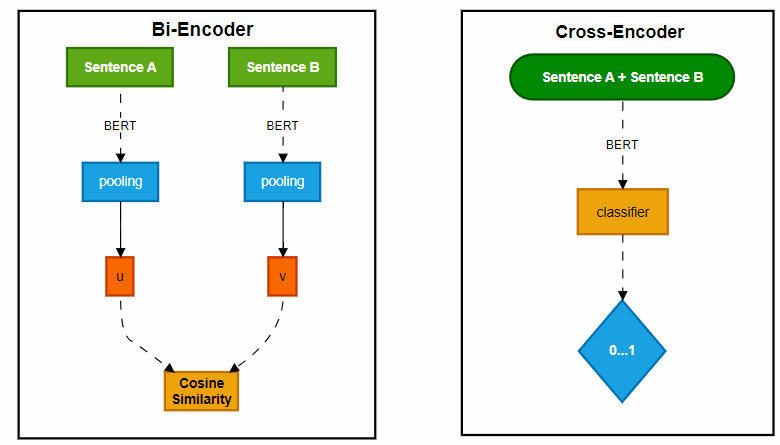

In [ ]:

from sentence_transformers import CrossEncoder

xenc_model = CrossEncoder("cross-encoder/ms-marco-TinyBERT-L-2")

def xenc_reranker(docs, summary):
    model_inputs = [[summary, passage] for passage in docs]
    scores = xenc_model.predict(model_inputs)
    results = [(input[1], score) for input, score in zip(model_inputs, scores)]
    
    return sorted(results, key=lambda x: x[1], reverse=True)
    
retrieval_chain_rerank_x_enc = (
    RunnableLambda(lambda summary: (hybrid_search(summary), summary))
    | RunnableLambda(lambda results_summary: (reciprocal_rank_fusion(results_summary[0]), results_summary[1]))
    | RunnableLambda(lambda results_summary: ([doc for doc, score in results_summary[0][:3]], results_summary[1]))
    | RunnableLambda(lambda results_summary: xenc_reranker(*results_summary))
)

result = retrieval_chain_rerank_x_enc.invoke(summary)

print("\nColBERT reranker results:")
for doc, score in result:
    print(f"[{score:.5f}]\t{doc}".replace("\n", " "))

Re-Ranking as an operation is also supported by services like `Cohere`.

The whole process of hybrid search and reranking is available within multiple services, like `Azure AI Search`, `ElasticSearch`, `Quadrant`,  `Vespa`, `Pinecone`, etc, whit integraiton is also supported by `langchain`.

In [ ]:
# Azure AI Search Hybrid
# Cohere

## Add filtering by metadata
Filtering by metadata is a common use case in search engines, we can utilize any specific data store or database api to filter the data, or we can use `langchain` retrievers capabilities to filter the data based on metadata.

In [ ]:
# filter with self query filter
# time-weighted retriever
# get doc from chunks
import os

from qdrant_client import models
from langchain_chroma import Chroma
from langchain.storage import InMemoryStore
from langchain.retrievers import ParentDocumentRetriever

all_docs = js_docs + md_docs + other_docs + commit_docs

file_list = [file.replace('/', os.path.sep) for file in get_changed_files()]
print(file_list)

all_docs_store = QdrantVectorStore(
    client=client,
    collection_name="generic_collection_hf_384",
    embedding=hfEmb
)
all_docs_store.add_documents(all_docs)

# {"filter": {"source": {"$in": file_list}}}
# InMemoryVectorStore.from_documents(all_docs, openAIEmb) 
# Chroma.from_documents(other_docs, openAIEmb)

results = all_docs_store.as_retriever().invoke("class AppTests\n  def render_should_use_react_router\n")
print("All results:")
print([doc.metadata['source'] for doc in results])

results = all_docs_store.as_retriever(
    search_kwargs={"filter": models.Filter(        
        must=[
            models.NestedCondition(
                nested=models.Nested(
                    key="metadata",
                    filter=models.Filter(
                        must=[
                            models.FieldCondition(key="source",match=models.MatchAny(any=file_list)),
                        ]
                    ),
                )
            )
        ]) }).invoke("class AppTests\n  def render_should_route_to_home\n")

print("Recent results:")
print(results)

# combine chunks
# The vectorstore to use to index the child chunks
# vectorstore = Chroma(collection_name="full_documents", embedding_function=hfEmb)

vectorstore = InMemoryVectorStore(hfEmb)
store = InMemoryStore()
retriever = ParentDocumentRetriever(
    vectorstore=vectorstore,
    docstore=store,
    child_splitter=js_splitter,
)

retriever.add_documents(jsData, ids=None)

results = retriever.invoke("class AppTests\n  def render_should_route_to_home\n")

print("Combined results:")
print(results)

question = "// create tests for new app feature"

Let's try to create a filter for the search results based on the query itself.

In [ ]:
from langchain_core.pydantic_v1 import BaseModel, Field

class CodeSearch(BaseModel):
    code_search: str = Field(
        ...,
        description="The code search query")
    doc_search: str = Field(
        ...,
        description="The documentation and guidelines search query"
        "Should be used to apply rules for certain type of code")
    language: str = Field(
        ...,
        description="The language of the code search query")
    source: str = Field(
        ...,
        description="The alias or wildcard of code file or library that can be related to a query")
    file_name: str = Field(
        ...,
        description="Possible name of a file or library that can be related to a query")
    updated_since: str = Field(
        ...,
        description="The date since the code was last updated")
    framework: str = Field(
        ...,
        description="The framework of the code search query")
    
    def pretty_print(self) -> None:
        for field in self.__fields__:
            if getattr(self, field) is not None and getattr(self, field) != getattr(
                self.__fields__[field], "default", None
            ):
                print(f"{field}: {getattr(self, field)}")

system = """You are an expert at converting user questions into database queries. \
You have access to a database of source code of a web service created for test purposes. \
Given a question, return a database query optimized to retrieve the most relevant code.

If there are acronyms or words you are not familiar with, do not try to rephrase them.
Today is october 2024"""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

structured_llm = chat.with_structured_output(CodeSearch)
query_analyzer = prompt | structured_llm

filter = query_analyzer.invoke({"question": question})

filter.pretty_print()


In [ ]:
import fnmatch

def metadata_filter(filter):
    field_filters = {
        "source": lambda doc, value: fnmatch.fnmatch(doc.metadata.get("source"), value),
        "file_name": lambda doc, value: fnmatch.fnmatch(doc.metadata.get("file_name"), value),
        "updated_since": lambda doc, value: doc.metadata.get("updated_since") > value,
    }
    def filter_doc(doc):
        for key, value in filter.dict().items():
            if value is not None and doc.metadata is not None and doc.metadata.get(key) is not None:
                if key in field_filters:
                    return field_filters[key](doc, value)
                return doc.metadata.get(key) == value
        return True

    return filter_doc

retriever.search_kwargs = {}
results = retriever.invoke(question)
print("Results:")
print(len(results))

retriever.search_kwargs = {"filter": metadata_filter(filter)}

results = retriever.invoke(question)
print("Filtered results:")
print(len(results))

Usually it makes more sense not to filter out data based on timestamnps but rather update scoring of the search result, so that data is not lost but ranked accordingly. For example, langchain time-weighted vector store retriever uses a combination of semantic similarity and a time decay.

```
semantic_similarity + (1.0 - decay_rate) ^ hours_passed
```

In [ ]:
# time-weighted vector store

import datetime
import random
import faiss
from langchain_community.docstore import InMemoryDocstore
from langchain.retrievers import TimeWeightedVectorStoreRetriever
from langchain_community.vectorstores import FAISS
from langchain_core.utils import mock_now

embedding_size = 1536
index = faiss.IndexFlatL2(embedding_size)
faiss_vectorstore = FAISS(openAIEmb, index, InMemoryDocstore({}), {})
faiss_vectorstore.add_documents(md_docs)

result = faiss_vectorstore.similarity_search_with_score("How to use React Router", k=5)

print("Similarity search results:")
for doc, score in result:
    print(f"[{score:.5f}]\t{doc.page_content}".replace("\n", " "))

for doc in md_docs:
    random_days = random.randint(0, 6)
    random_seconds = random.randint(0, 86399)  # 86399 seconds in a day
    random_time_delta = datetime.timedelta(days=random_days, seconds=random_seconds)
    doc.metadata["last_accessed_at"] = datetime.datetime.now() - random_time_delta

retriever = TimeWeightedVectorStoreRetriever(
    vectorstore=faiss_vectorstore,
# high decay rate, the recency score quickly goes to 0. If you set this all the way to 1, recency is 0 for all objects, making this equivalent to a vector lookup.
    decay_rate=0.999,
# low decay rate means memories will be "remembered" for longer. A decay rate of 0 means memories never be forgotten, making this equivalent to a vector lookup.
    #decay_rate=0.0000000000000000000000001,
    k=5
)

retriever.add_documents(md_docs)
result = retriever.invoke("How to use React Router")

print("\nSearch with time weighting:")
for doc in result:
    print(f"[{doc.metadata['updated_since']}]\t{doc.page_content}".replace("\n", " "))

In [ ]:
# Routing for different sources

from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI

# Data model
class RouteQuery(BaseModel):
    datasource: Literal["python_docs", "js_docs", "csharp_docs"] = Field(
        ...,
        description="Given a user question choose which datasource would be most relevant for answering their question",
    )

route_llm = chat.with_structured_output(RouteQuery)

system = """You are an expert at routing a user question to the appropriate data source.

Based on the programming language the question is referring to, route it to the relevant data source."""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("user", "{question}"),
    ]
)

# Define router 
router = prompt | route_llm

question = """Why doesn't the following code work:

from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages(["human", "speak in {language}"])
prompt.invoke("french")
"""

result = router.invoke({"question": question})

print("Route result:", result.datasource)


Data retrieval appears more complicated when we are trying to find the most relevant data based on the input. You can follow these concepts when working with langchain stack here https://python.langchain.com/docs/concepts/#retrieval 

## Prompt
The final prompt will be a combination of the context and the query. Its structure is strongly dependent on the use case, the data we have and LLM that is used. For example for completions we can use special purpose **Stable Code** models that will require quite strict structure of the prompt.

Sometimes it can be useful to apply defferent prompts depending on the context of the search, for example if we are looking for a code completion we can use a prompt that will be more specific to the certain code.

In [ ]:
from langchain.utils.math import cosine_similarity
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableLambda, RunnablePassthrough

# Prompt selection based on the context
js_template = """You are JS sxpert and should be able to write tests for the code snippet. Consider the following example:
Code snippet:
```
class Calculator {
    add(a, b) {
        return a + b;
    }
}
```
Correct output:
class CalculatorTests {
    @Test
    public void testAdd() {
        var calculator = new Calculator();
        assertEquals(5, calculator.add(2, 3));
    }
}
"""

cs_template = """You are C# sxpert and should be able to write tests for the code snippet. Consider the following example:
Code snippet:
```
public class Calculator {
    public int Add(int a, int b) => a + b;
}
```
Correct output:
[TextFixture]
class CalculatorTests {

    [TestCase(2, 3, 5)]    
    [TestCase(0, -1, -1)]
    public void testAdd(int a, int b, int expected) {
        var calculator = new Calculator();

        Assert.AreEqual(expected, calculator.Add(a, b));
    }
}
"""

prompt_templates = [js_template, cs_template]
prompt_embeddings = openAIEmb.embed_documents(prompt_templates)

def prompt_router(input):
    code_snippet = input["code"]

    # Embed question
    query_embedding = openAIEmb.embed_query(code_snippet)

    # Compute similarity
    similarity = cosine_similarity([query_embedding], prompt_embeddings)[0]
    most_similar = prompt_templates[similarity.argmax()]

    # Chosen prompt 
    print("Selected Lang:", most_similar == js_template and "JS" or "C#")

    input["system"] = most_similar

    return ChatPromptTemplate.from_messages(
    [
        ("system", "{system}"),
        ("user", "Create tests for the following code:\n{code}\n PROVIDE ONLY CODE AND NOTHING ELSE"),
    ])

chain = (
    {"code": RunnablePassthrough()}
    | RunnableLambda(prompt_router)
    | chat
    | StrOutputParser()
)

print(chain.invoke("""class App {
    public void render() {
        return <div>App</div>;
    }
}
"""))

print(chain.invoke("""public class HomeController {
    public IActionResult Index(string path)
    {
        if (string.IsNullOrEmpty(path))
        {
            return NotFound();
        }
        return View();
    }
}
"""))

In [ ]:
# FIM prompts

In [ ]:
# Tool calling

In [ ]:
# Multi modal input

## GraphRAG
https://microsoft.github.io/graphrag/ 

## Code Completions
LSP Completions - https://github.com/microsoft/language-server-protocol/blob/gh-pages/_specifications/lsp/3.18/language/completion.md
Continue.Dev custom RAG - https://docs.continue.dev/customize/tutorials/custom-code-rag